#Kamal's Code:


In [0]:
from random import randint, choice, seed
from pprint import pprint
from itertools import permutations
from math import inf as oo # Infinity (∞) is larger than any number
from math import sqrt
from time      import time
import matplotlib.pyplot as plt
import copy
from google.colab import files

In [0]:
MAX_DISTANCE = 100

def random_symmetric_graph(n):
    ''' Symmetric adjacency matrix of size nxn '''
    dist_matrix = [[oo for _ in range(n)] for _ in range(n)]
    for i in range(n):
        for j in range(i+1,n):
            v = randint(1,MAX_DISTANCE)
            dist_matrix[i][j] = v
            dist_matrix[j][i] = v
    return dist_matrix

def random_euclidean_graph(n, points=None):
    ''' Symmetric adjacency matrix of a Euclidean graph of size nxn '''
    dist_matrix = [[oo for _ in range(n)] for _ in range(n)]

    if not points: #so we can pass it our own points as well
        points = []
        for p in range(n):
            x,y = randint(0,MAX_DISTANCE), randint(0,MAX_DISTANCE)
            points.append((x,y))
    for i in range(n):
        p1 = points[i]
        for j in range(i+1,n):
            p2 = points[j]
            distance = sqrt((p1[0]-p2[0])**2+(p1[1]-p2[1])**2)
            dist_matrix[i][j] = distance
            dist_matrix[j][i] = distance
    return points, dist_matrix

def show(G):
    ''' Show adjacency matrix. Useful for debugging. '''
    n = len(G)
    r = "     "
    for i in range(n):
        r += f'{i:4}'
    r += '\n    -'+'-'*(4*n)+'\n'
    for i in range(n):
        r += f'{i:2} | '
        for j in range(n):
            r += f'{G[i][j]:4}'
        r += '\n'
    r = r.replace('inf', '  ∞')
    print(r)

def cost(G, cycle):
    ''' Calculate the cost of the given cycle '''
    c = 0
    n = len(G)
    for i in range(n):
        a = cycle[i]
        b = cycle[(i+1)%n]
        c += G[a][b]
    return c
    
def greedy_nearest_neighbours(G, endpoints=None):
    H = copy.deepcopy(G) # We need the original G. We work on/modify H
    n = len(H)
    cities = list(range(n))
    cycle = [] # solution to be built
    city = 0 # Start city
    while len(cities)>0:
        # Find nearest neighbour
        city_neighbours = H[city]
        smallest_distance = min(city_neighbours)
        nearest_city = city_neighbours.index(smallest_distance)
        # Update 'cycle' and 'cities' and H then 'city'
        cycle.append(city)
        cities.remove(city)
        for i in range(n): # 'city' is not to be used again!
            H[city][i] = oo
            H[i][city] = oo
        city = nearest_city
    return cycle

def exhaustive_search(G, endpoints=None):
    n = len(G)    
    best_cost = oo # infinity
    best_cycle = []
    for cycle in permutations(range(1,n)): # permutations of [1,2,...,n-1]
        cycle=[0]+list(cycle)              # add the starting city: 0
        c = cost(G, cycle)
        if c < best_cost:
            best_cost = c
            best_cycle = cycle
    return best_cycle

# Best Algorithm TSP, ref: https://github.com/dmishin/tsp-solver

In [32]:
!pip3 install tsp_solver2

In [0]:
from tsp_solver.greedy import solve_tsp

# Creating Dataset 


In [0]:
#Randomly Generated

graphList = []
pointsList = []
for i in range(2, 201): # Create 200 graphs of sizes [2,202]
    for j in range(25): # do it 25 times each
        points, graph = random_euclidean_graph(i)
        graphList.append(graph)
        pointsList.append(points)

In [34]:
## From Existing Points in File

points_file = files.upload()

Saving points_concorde.txt to points_concorde (6).txt


In [0]:
pointsList=[]
for line in points_file["points_concorde.txt"].decode().split("\n")[:-1]:
    points= line[2:-2].split("), (")
    interList = []
    for point in points:
        point1=point.split(", ")[0]
        point2=point.split(", ")[1]
        interList.append((float(point1),float(point2)))
    pointsList.append(interList)
counter=0
graphList=[]
for i in range(2, 201): # Create 100 graphs of sizes [2,101]
    for j in range(25): # do it 25 times each
        points, graph = random_euclidean_graph(i, pointsList[counter])
        graphList.append(graph)
        counter +=1

# Utility Functions

In [0]:
def plotPoints(points):
    plt.scatter(*zip(*points))
    for i in range(len(points)):
        for j in range(i, len(points)):
            plt.plot([points[i][0], points[j][0]], [points[i][1], points[j][1]])
    plt.show()

def plotSolution(solution, points):
    finalPoints = []
    for city in solution:
        for point in range(len(points)):
            if city==point:
                finalPoints.append(points[point])
    plt.scatter(*zip(*finalPoints))
    for i in range(len(points) -1):
        plt.plot([finalPoints[i][0], finalPoints[i+1][0]], [finalPoints[i][1], finalPoints[i+1][1]])
    plt.show()

def get_percentage_delta(graphList, allCosts1, allCosts2):
    """ allSolutions = [(solution0, solution1), ...]
        solution0 being always the correct one"""

    costTotal1 = 0
    costTotal2 = 0 
    percentageDelta = []
    currentSize = 2 #always start at length 2

    for cost1, cost2, graph in zip(allCosts1, allCosts2, graphList):
        if len(graph) == currentSize: #so we average the same size graphs
            costTotal1 += cost1
            costTotal2 += cost2
        else:
            percentageDelta.append(costTotal1 / costTotal2 * 100)
            costTotal1 = 0
            costTotal2 = 0 
            currentSize = len(graph) #advance onto the next size

    return percentageDelta

def get_solutions_costs_times(tsp_function, graphList, maxTime=oo):

    allSolutions= []
    allCosts = []
    allTimes = []
    for graph in graphList: #looping over graphs
        start = time()
        pathAlgorithm = tsp_function(graph)
        totalTime = time() - start
        allSolutions.append(pathAlgorithm)
        allCosts.append(cost(graph, pathAlgorithm))
        allTimes.append(totalTime)
        if maxTime < totalTime:
            break

    return allSolutions, allCosts, allTimes

def filter_costs_times(solutions, costs, times):

    filteredTimes = []
    filteredCosts = []
    timeTotal = 0
    costTotal = 0
    averageCounter = 0
    currentSize = 2 #always start at length 2
    for solution, cost, time in zip(solutions, costs, times):
        if len(solution) == currentSize: #so we average the same size graphs
            timeTotal += time
            costTotal += cost
            averageCounter += 1
        else:
            filteredTimes.append(timeTotal / averageCounter)
            filteredCosts.append(costTotal / averageCounter)
            timeTotal = 0
            costTotal = 0
            averageCounter = 0
            currentSize = len(solution) #advance onto the next size

    return filteredCosts, filteredTimes

# Sending and receiving data fo PyConcorde Computation

In [0]:
# Exporting PointsList to file for Concorde Processing

file1= open("points_concorde.txt", "w")
for point in pointsList:
    outputStream = "["
    for element in point:
        outputStream += str(element) + ", "
    file1.write(outputStream[:-2] + "]\n")
files.download("points_concorde.txt")

In [42]:
# Importing Solutions and Time from Concorde output files

concorde_file_solutions = files.upload() #Solutions only work from index 50 onwards
concorde_file_times = files.upload() #Only from 50 onwards

Saving output_solutions.txt to output_solutions.txt


Saving output_time.txt to output_time.txt


In [0]:
# Parsing files into standardised format

pyc_sols=[[0,1]]*25 + [[0,1,2]]*25
#doesn't work under 2 cities, so we populate 2*25 elements with [0,1] and [0,1,2]
for line in concorde_file_solutions["output_solutions.txt"].decode().split("\n")[:-1]:
    tempSol=[]
    for element in line[1:-1].split(","):
        tempSol.append(int(element))
    pyc_sols.append(tempSol)

pyc_times=[0]*50
for line in concorde_file_times["output_time.txt"].decode().split("\n")[:-1]:
    pyc_times.append(float(line))

pyc_costs=[]
for solution, graph in zip(pyc_sols, graphList):
    pyc_costs.append(cost(graph, solution))

# Computing TSP-Solver, GreedyNN, Exhaustive, PyConcorde

In [0]:
sol1, cost1, time1 = get_solutions_costs_times(solve_tsp, graphList)
sol2, cost2, time2 = get_solutions_costs_times(greedy_nearest_neighbours, graphList)
sol3, cost3, time3 = get_solutions_costs_times(exhaustive_search, graphList, maxTime=3)

# Filtering averages out 25 same length cities into 1 result. 
# In the end this leaves us with a 200 element list, down from 5000. 

filter_cost_tsp, filter_time_tsp = filter_costs_times(sol1, cost1, time1)
filter_cost_gnn, filter_time_gnn = filter_costs_times(sol2, cost2, time2)
filter_cost_pyc, filter_time_pyc = filter_costs_times(pyc_sols, pyc_costs, pyc_times)
filter_cost_exh, filter_time_exh = filter_costs_times(sol3, cost3, time3)

# Showing different solution approaches at 200 cities 

All possible paths.


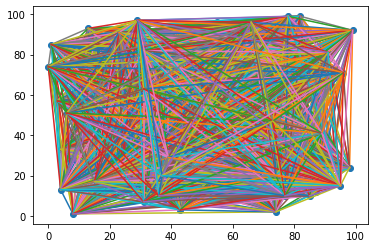

Cost of GreedyNN solution:  881


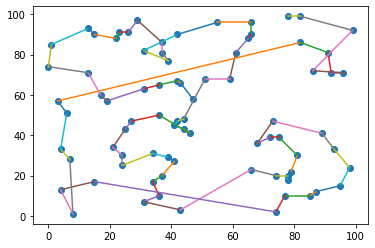

Cost of TSP-Solver solution:  808


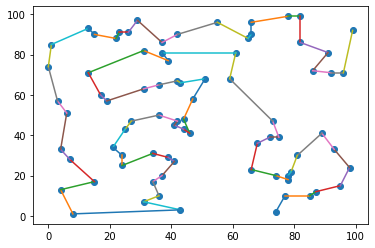

Cost of PyConcorde solution:  707


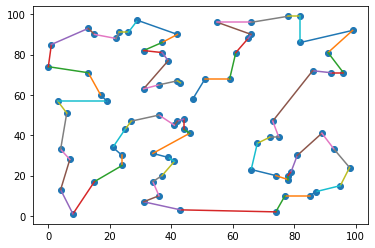

In [46]:
n = 1970 #[2,201] each 25 times, graph 4970 --> 200 cities

print("All possible paths.")
plotPoints(pointsList[n])

print("Cost of GreedyNN solution: ", round(cost2[n]))
plotSolution(sol2[n], pointsList[n])
print("Cost of TSP-Solver solution: ", round(cost1[n]))
plotSolution(sol1[n], pointsList[n])
print("Cost of PyConcorde solution: ", round(pyc_costs[n]))
plotSolution(pyc_sols[n], pointsList[n])

# Cost (20c): GreedyNN vs TSP-Solver  vs PyConcorde vs Exhaustive

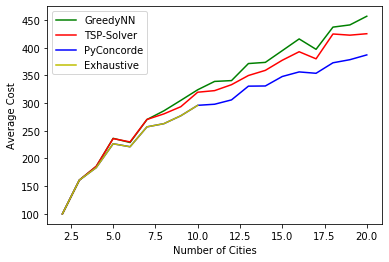

In [47]:
plt.plot(range(2, 21) , filter_cost_gnn[:19], 'g', label="GreedyNN")
plt.plot(range(2, 21) , filter_cost_tsp[:19], 'r', label="TSP-Solver")
plt.plot(range(2, 21) , filter_cost_pyc[:19], 'b', label="PyConcorde")
plt.plot(range(2, 11) , filter_cost_exh, 'y', label="Exhaustive")

plt.xlabel("Number of Cities")
plt.ylabel("Average Cost")
plt.legend()
plt.show()

## Time (20c): GreedyNN vs TSP-Solver vs PyConcorde vs Exhaustive

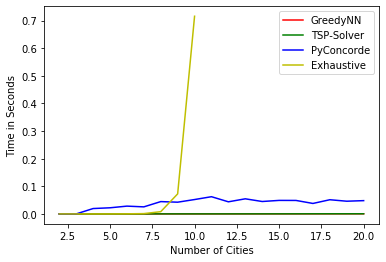

In [48]:
plt.plot(range(2, 21) , filter_time_gnn[:19], 'r', label="GreedyNN")
plt.plot(range(2, 21) , filter_time_tsp[:19], 'g', label="TSP-Solver")
plt.plot(range(2, 21) , filter_time_pyc[:19], 'b', label="PyConcorde")
plt.plot(range(2, 11) , filter_time_exh, 'y', label="Exhaustive")

plt.xlabel("Number of Cities")
plt.ylabel("Time in Seconds")
plt.legend()
plt.show()


# Quality (200c): GreedyNN vs TSP-Solver  vs PyConcorde


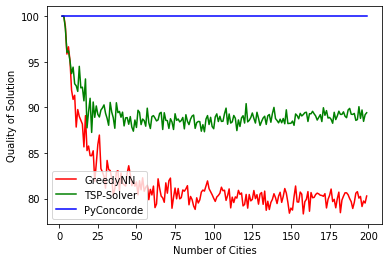

In [53]:
tsp_vs_pyc = get_percentage_delta(graphList, pyc_costs, cost1)
gnn_vs_pyc = get_percentage_delta(graphList, pyc_costs, cost2)

plt.plot(range(2, 200) , gnn_vs_pyc, 'r', label="GreedyNN")
plt.plot(range(2, 200) , tsp_vs_pyc, 'g', label="TSP-Solver")
plt.plot(range(2, 200), [100]*198, "b", label="PyConcorde")

plt.xlabel("Number of Cities")
plt.ylabel("Quality of Solution")
plt.legend()
plt.show()

## Cost (200c):  GreedyNN vs TSP-Solver vs PyConcorde

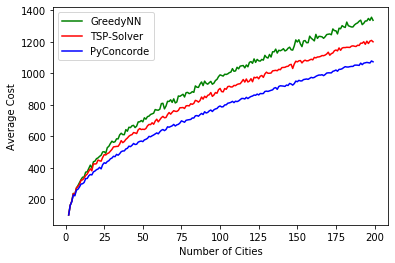

In [50]:
plt.plot(range(2, 200) , filter_cost_gnn, 'g', label="GreedyNN")
plt.plot(range(2, 200) , filter_cost_tsp, 'r', label="TSP-Solver")
plt.plot(range(2, 200) , filter_cost_pyc, 'b', label="PyConcorde")

plt.xlabel("Number of Cities")
plt.ylabel("Average Cost")
plt.legend()
plt.show()

# Time (200c): GreedyNN vs TSP-Solver vs PyConcorde


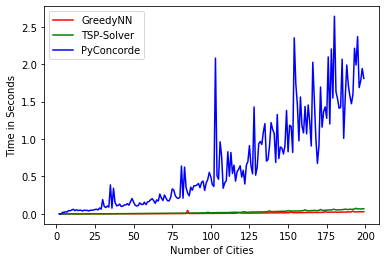

In [51]:
plt.plot(range(2, 200) , filter_time_gnn, 'r', label="GreedyNN")
plt.plot(range(2, 200) , filter_time_tsp, 'g', label="TSP-Solver")
plt.plot(range(2, 200) , filter_time_pyc, 'b', label="PyConcorde")

plt.xlabel("Number of Cities")
plt.ylabel("Time in Seconds")
plt.legend()
plt.show()